### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [317]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [318]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [319]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

## Change these to select data

In [320]:
table_names = ['civil_liberties', \
               'political_rights', \
               #'freedom_status', \
               #'corruption_perception', \
               'female_legislators', \
               'population_growth', \
               'population_female', \
               #'under_5_mortality', \
               'life_expectancy', \
               #'population_0_14', \
               'population_15_64',  \
               #'population_65_up', \
               #'terror_new', \
               #'peace_new', \
               #'refugees_percapita', \
               'zscores']

In [321]:
x_cols = table_names[:-1]

In [322]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [323]:
full_data = pd.DataFrame()

In [324]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['year', 'countrycode'])
    full_data = pd.concat([full_data, year_data])
    


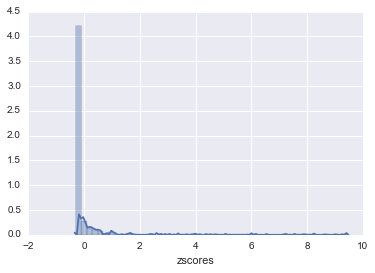

In [325]:
sns.distplot(full_data.dropna()['zscores'].astype(float))

(array([ 989.,   22.,    7.,    7.,    7.,    2.,    3.,    3.,    5.,    4.]),
 array([-0.29313644,  0.67991785,  1.65297214,  2.62602643,  3.59908072,
         4.57213501,  5.5451893 ,  6.51824359,  7.49129788,  8.46435217,
         9.43740646]),
 <a list of 10 Patch objects>)

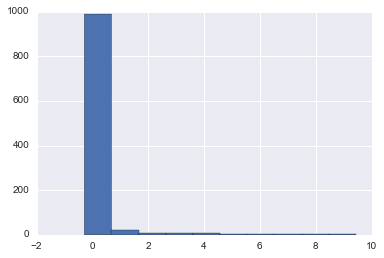

In [326]:
import pylab as pl

pl.hist(sorted(list(full_data.dropna()['zscores'].astype(float))))



In [327]:
full_data.head()

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 AFG                        6                 5                27.7   
     AGO                        5                 6                37.3   
     ALB                        3                 3                 7.1   
     ARE                        5                 6                22.5   
     ARG                        2                 2                40.0   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 AFG                   2.485315          48.512909        58.225024   
     AGO                   3.374180          50.493712        49.847390   
     ALB                  -0.767343          49.610212        76.632317   
     ARE                  13.810060          25.880062        76.307756   
     ARG                   1.025393          51.087196        75.166268   

                  population_15_64       zscores  
year countrycode                                  
2008 AFG                 49.946087   6.546331355  
     AGO                 49.356104   0.281696206  
     ALB                 66.816430   0.055357722  
     ARE                 84.600650  -0.267222176  
     ARG                 63.456290   -0.26793528

In [328]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [329]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 FJI                        4                 6                 NaN   
     GIN                        5                 7                 NaN   
     LUX                        1                 1                23.3   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     TKM                        7                 7                 NaN   
     VUT                        2                 2                 3.8   
2009 FJI                        4                 6                 NaN   
     GIN                        6                 7                 NaN   
     LUX                        1                 1                20.0   
     MDG                        4                 6                 NaN   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     VUT                        2                 2                 3.8   
     WSM                        2                 2                 8.2   
2010 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     LUX                        1                 1                20.0   
     NER                        4                 5                 NaN   
     SSD                      NaN               NaN                 NaN   
     TZA                        3                 3                 NaN   
2011 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     HRV                        2                 1                23.8   
     LBY                        6                 7                 NaN   
     LUX                        1                 1                25.0   
     ZAR                        6                 6                 NaN   
2012 FJI                        4                 6                 NaN   
     GHA                        2                 1                 NaN   
     GIN                        5                 5                 NaN   
     LKA                        4                 5                 5.8   
     LUX                        1                 1                21.7   
2013 ARG                        2                 2                 NaN   
     CAF                        7                 7                 NaN   
     EGY                        5                 6                 NaN   
     FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 FJI                   1.010417          48.947707        69.022024   
     GIN                   2.671069          49.966108        54.777585   
     LUX                   1.787497          50.493425        80.539024   
     MMR                   0.651129          51.176312        64.367610   
     SSD                   4.362664          50.051550        52.593317   
     TKM                   1.213341          50.724437        64.756073   
     VUT                   2.416066          49.142388        70.254756   
2009 FJI                   1.020386          48.947824        69.202854   
     GIN                   2.728375          49.955495        55.556146   
     LUX                   1.851775          50.416014        80.636585   
     MDG                   2.814994          50.195519        62.918171   
     MMR                   0.663518          51.184720        64.643561   
     SSD                   4.403674       

In [330]:
full_data = full_data.dropna()

In [331]:
#Get Z scores of rows
#for col in x_cols:
#    full_data[col] = full_data[col].astype(float)
#    full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


#### Get the score values WITHOUT cross validating 

In [437]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True,
                   get_prediction=False
                  ):
    y_test_index=y_test.index
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    roc_auc_value = roc_auc_score(y_test,y_pred)
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: ()'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value, \
                                                                       roc_auc_value))
    elif get_prediction:
        y_pred=pd.Series(y_pred, index=y_test_index)
        return y_pred
        
    else:
        return accuracy_score_value, \
               precision_score_value, \
               recall_score_value, \
               f1_score_value, \
               roc_auc_value, \
               feature_importances

In [333]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [334]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9015873015873016
Precision: 0.6296296296296297
Recall: 0.7555555555555555
f1: 0.6868686868686867
ROC AUC: ()


In [335]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8571428571428571
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: ()


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [336]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7492063492063492
Precision: 0.3111111111111111
Recall: 0.6222222222222222
f1: 0.4148148148148148
ROC AUC: ()


In [337]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9238095238095239
Precision: 0.8
Recall: 0.6222222222222222
f1: 0.7000000000000001
ROC AUC: ()


In [338]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9174603174603174
Precision: 0.7714285714285715
Recall: 0.6
f1: 0.675
ROC AUC: ()


#### Print the ROC curve for a model

In [339]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.9538271604938271


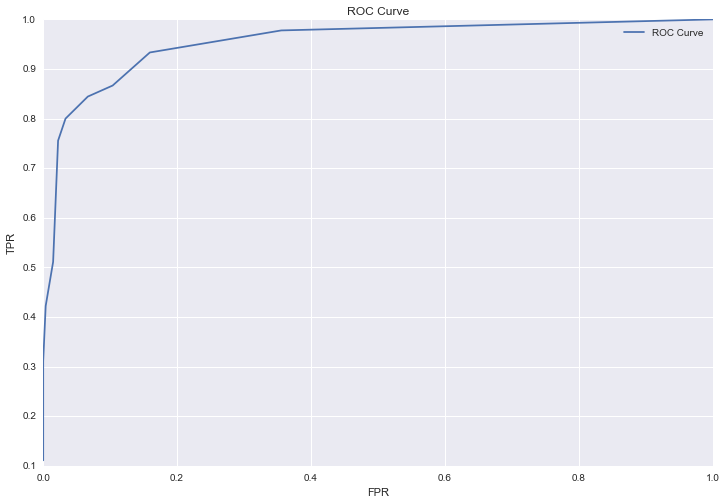

In [340]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

#### Cross Validate and Return Scores 

In [341]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=1)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [342]:
getScoreValuesByCV(X,y)

Accuracy: 0.9647202884419148
Precision: 0.8726392961876833
Recall: 0.897983870967742
f1: 0.8842950890033432
ROC AUC: 0.9372192909543374


In [343]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9494274246581554
Precision: 0.9077182077182078
Recall: 0.6689516129032259
f1: 0.7814942391973806
ROC AUC: 0.9714285687167037


In [344]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7207147554366313
Precision: 0.28659782556715907
Recall: 0.5798387096774194
f1: 0.38337993592387665
ROC AUC: 0.7184708855325689


In [345]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.9351731331776231
Precision: 0.8257792207792208
Recall: 0.7570564516129032
f1: 0.7797050971627243
ROC AUC: 0.8644924634664409


In [346]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8656069298623551
Precision: 1.0
Recall: 0.10221774193548387
f1: 0.18270944741532977
ROC AUC: 0.7415923711327682


## Modeling with Over Sampling of Training Set

In [347]:
def oversample_data(X_t, y_t, ratio):
    x_columns = X_t.columns
    
    X_t = X_t.reset_index(drop=True).as_matrix()
    y_t = y_t.reset_index(drop=True).as_matrix()

    smote = OverSampler(ratio=ratio, verbose=False)
    smox, smoy = smote.fit_transform(X_t, y_t)
    X_t = pd.DataFrame(smox, columns=x_columns)
    y_t = pd.Series(smoy)
    return X_t, y_t


In [348]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [349]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])

X_train, y_train = oversample_data(X_train, y_train, ratio)

In [350]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.8888888888888888
Precision: 0.5714285714285714
Recall: 0.8888888888888888
f1: 0.6956521739130435
ROC AUC: ()


In [351]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9428571428571428
Precision: 0.7872340425531915
Recall: 0.8222222222222222
f1: 0.8043478260869565
ROC AUC: ()


In [352]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.7873015873015873
Precision: 0.21052631578947367
Recall: 0.17777777777777778
f1: 0.19277108433734938
ROC AUC: ()


In [353]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6063492063492063
Precision: 0.2074074074074074
Recall: 0.6222222222222222
f1: 0.3111111111111111
ROC AUC: ()


In [354]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.9142857142857143
Precision: 0.68
Recall: 0.7555555555555555
f1: 0.7157894736842104
ROC AUC: ()


In [355]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.6984126984126984
Precision: 0.2549019607843137
Recall: 0.5777777777777777
f1: 0.35374149659863946
ROC AUC: ()


## Confusion Matrix

In [356]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with or without oversampling

## getCrossValScoresBySSS

This class is instantiated by doing the following:
    
    yourinstance = getCrossValScoresBySSS(X, y, test_size=0.3, n_iter=30)
    
Where:
* X is a pandas dataframe of the features
* y is a series of the classifiers
* test_size is the test size for the train/test splits
* n_iter is the number of iterations for cross validation

This object has the following methods:

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)
    
    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta,  get_models_avg=False, get_features=True, get_cm=False, verbose=True)
    
    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

### get_multi_models

    yourinstance.get_multi_models(oversample=True, year=None, year_delta=0)

Where:
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 

This returns a dataframe with the Accuracy, Precision, Recall, F1, and ROC AUC scores for various models.

### get_single_model

    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, year=None, year_delta=0,  get_features=True, get_cm=False, verbose=True)
    
Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 
* get_features is a boolean value. If True it will attempt to get the feature importances of the model.
* get_cm is a boolean value. If True it will output a confusion matrix of the model (or the average prediction).
* verbose is a boolean value. If True it will print out the score values for Accuracy, Precision, Recall, F1, and ROC AUC. If False it will just return them.

### future_crisis_countries

    future_crisis_countries(model=KNeighborsClassifier(n_neighbors=2), oversample=True,year=None,year_delta=0)

Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* year is the starting year for which features will be examined
* year_delta is used in the equation predicted_year = year + year_delta 


In [458]:
class getCrossValScoresBySSS(object):
    
    def __init__(self, 
                 local_X, 
                 local_y,
                 test_size=0.3,
                 n_iter=50
                ):
        self.model_list = [\
                          KNeighborsClassifier(n_neighbors=2), \
                          SVC(), \
                          LogisticRegression(), \
                          BernoulliNB(), \
                          GaussianNB(), \
                          RandomForestClassifier(n_estimators=30), \
                          DecisionTreeClassifier() \
                          ]
        
        self.index_func = [\
                          'KNeighborsClassifier(n_neighbors=2)', \
                          'SVC()', \
                          'LogisticRegression()', \
                          'BernoulliNB()', \
                          'GaussianNB()', \
                          'RandomForestClassifier(n_estimators=30)', \
                          'DecisionTreeClassifier()' \
                          ]
        
        self.initialize_scores()
        self.score_dict = {}
        
        self.X = local_X
        self.y = local_y
        self.x_cols = list(local_X.columns)
        self.ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
        self.sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    def initialize_scores(self):
        self.acc_array = []
        self.prec_array = []
        self.recall_array = []
        self.f1_array = []
        self.roc_auc_array = []
        self.feature_imp_array = []
        
    def get_cm_pred(self, model, X_t, y_t, X_ts):
        temp_model = model
        temp_model.fit(X_t, y_t)
        y_pd = temp_model.predict(X_ts)
        return y_pd
    
    def test_conversion_for_year(self, year, y_delta):
        #try:
            new_year = year+y_delta
            X_columns = self.X.columns
            X_te = self.X.loc[year, :]
            y_te = self.y.loc[new_year, :]
            y_te = y_te.reset_index('countrycode').reset_index(drop=True).set_index('countrycode')
            full = pd.concat([X_te, y_te], axis=1)
            full = full.dropna()
            X_te = full[X_columns]
            y_te = full['zscores']
            return X_te, y_te

        #except:
         #   print('Bad Year')
    
    def set_score_arrays(self, oversample, year, year_delta, model, get_features):
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)

            if year != None:
                X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

            accuracy_score_value, precision_score_value, \
            recall_score_value, f1_score_value, roc_auc_value, \
            feature_importances = getScoreValues(X_train,
                                                 X_test,
                                                 y_train,
                                                 y_test,
                                                 model=model,
                                                 verbose=False,
                                                 get_features=get_features)

            self.acc_array.append(accuracy_score_value)
            self.prec_array.append(precision_score_value)
            self.recall_array.append(recall_score_value)
            self.f1_array.append(f1_score_value)
            self.roc_auc_array.append(roc_auc_value)
            self.feature_imp_array.append(feature_importances) 
    
    def get_multi_models(self, oversample=True, year=None, year_delta=0):
        self.score_dict = {}
        models_acc = []
        models_prec = []
        models_rec = []
        models_f1 = []
        models_roc_auc = []
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        for a_model in self.model_list:
            self.initialize_scores()
            
            self.set_score_arrays(oversample=oversample,
                                  year=year,
                                  year_delta=year_delta,
                                  model=a_model,
                                  get_features=False)
                
            mean_acc = np.mean(self.acc_array)
            mean_prec = np.mean(self.prec_array)
            mean_recall = np.mean(self.recall_array)
            mean_f1 = np.mean(self.f1_array)
            mean_roc_auc = np.mean(self.roc_auc_array)
            
            models_acc.append(mean_acc)
            models_prec.append(mean_prec)
            models_rec.append(mean_recall)
            models_f1.append(mean_f1)
            models_roc_auc.append(mean_roc_auc)
            
        self.score_dict['Accuracy'] = models_acc
        self.score_dict['Precision'] = models_prec
        self.score_dict['Recall'] = models_rec
        self.score_dict['F1'] = models_f1
        self.score_dict['ROCAUC'] = models_roc_auc
        
        df = pd.DataFrame(self.score_dict, columns=col_names, index=self.index_func)
        return df
    
    def get_single_model(self,
                         model=KNeighborsClassifier(n_neighbors=2),
                         oversample=True,
                         year=None,
                         year_delta=0,
                         get_features=True,
                         get_cm=False,
                         verbose=True
                        ):
        
        self.initialize_scores()
        
        self.set_score_arrays(oversample=oversample,
                              year=year,
                              year_delta=year_delta,
                              model=model,
                              get_features=get_features) 
            
        if get_cm:
            # For getting a confusion matrix of the last model in the cross validated set
            y_pred = self.get_cm_pred(model, X_train, y_train, X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(self.acc_array)
        mean_prec = np.mean(self.prec_array)
        mean_recall = np.mean(self.recall_array)
        mean_f1 = np.mean(self.f1_array)
        mean_roc_auc = np.mean(self.roc_auc_array)
        try:
            mean_feature_imp = np.mean(self.feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
               
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(mean_acc, \
                                                                                        mean_prec, \
                                                                                        mean_recall,\
                                                                                        mean_f1, \
                                                                                        mean_roc_auc))

        else:
            return mean_acc, mean_prec, mean_recall, mean_f1, mean_roc_auc
        
    def future_crisis_countries(self,
                                model=KNeighborsClassifier(n_neighbors=2),
                                oversample=True,
                                year=None,
                                year_delta=0):
        
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)
            
            #Year prior is used later as the comparison between the desired year and its year prior
            _,year_prior = self.test_conversion_for_year(year=year, y_delta=(year_delta-1))
            if year != None:
                X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)
            
            prediction = getScoreValues(X_train, 
                                       X_test, 
                                       y_train, 
                                       y_test, 
                                       model=model, 
                                       verbose=False, 
                                       get_features=False,
                                       get_prediction=True
                                      )

            year_prior.name='year_prior'
            prediction.name='prediction'
            compare_df = pd.concat([year_prior, prediction], axis=1)
            compare_df = compare_df.dropna()
            compare_df['net'] = compare_df.year_prior.subtract(compare_df.prediction)
            future_crisis = compare_df[compare_df.net < 0]
            print(future_crisis)
            
    
    
    

In [459]:
X = full_data[x_cols]
y = full_data['zscores']

## Scores for various models

#### With oversampling

In [460]:
pol_modeling = getCrossValScoresBySSS(X,y)

In [461]:
pol_modeling.future_crisis_countries(year=2011, year_delta=2)

     year_prior  prediction  net
AGO           0           1   -1
TCD           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
LCA           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
MDV           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
DZA           0           1   -1
MDG           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
EST           0           1   -1
     year_prior  prediction  net
AGO           0           1   -1
LBN           0           1   -1
     year_prior  prediction  net
AGO       

In [398]:
pol_modeling.get_multi_models()

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.952889,0.830227,0.864681,0.845039,0.916520
SVC(),0.955175,0.854650,0.846809,0.848831,0.910494
LogisticRegression(),0.661524,0.255206,0.660851,0.367707,0.661246
BernoulliNB(),0.785714,0.240333,0.182979,0.197596,0.537198
GaussianNB(),0.579111,0.210063,0.662128,0.318679,0.613340
RandomForestClassifier(n_estimators=30),0.956762,0.865203,0.844681,0.853302,0.910549
DecisionTreeClassifier(),0.932254,0.785769,0.755745,0.768468,0.859477


#### Without oversampling

In [361]:
pol_modeling.get_multi_models(oversample=False)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.933714,0.867747,0.658723,0.746120,0.820332
SVC(),0.939492,0.912225,0.659149,0.762346,0.823903
LogisticRegression(),0.864444,0.906198,0.102979,0.182045,0.550482
BernoulliNB(),0.850794,0.000000,0.000000,0.000000,0.500000
GaussianNB(),0.719365,0.282105,0.565532,0.375698,0.655938
RandomForestClassifier(n_estimators=30),0.944000,0.883053,0.722553,0.792526,0.852695
DecisionTreeClassifier(),0.929587,0.761747,0.774894,0.766368,0.865805


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.9554920634920636
Precision: 0.8318930059410446
Recall: 0.8825531914893616
f1: 0.8549977188416509
ROC AUC: 0.925418386789457


n =  2
Avg Feature Importance: None
Accuracy: 0.95415873015873
Precision: 0.8387063064189795
Recall: 0.8642553191489363
f1: 0.8491755949181352
ROC AUC: 0.9170903461416323


n =  3
Avg Feature Importance: None
Accuracy: 0.9307301587301586
Precision: 0.7082650276696876
Recall: 0.9238297872340426
f1: 0.8003154575483954
ROC AUC: 0.9278850428707528




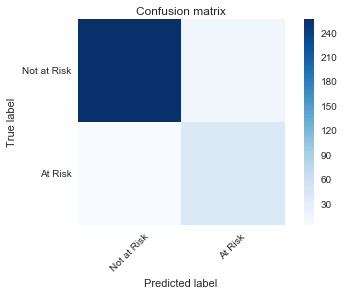

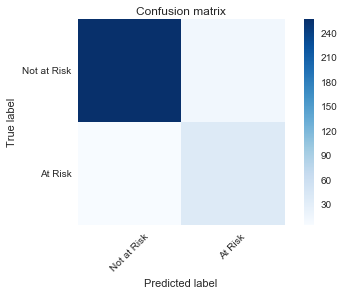

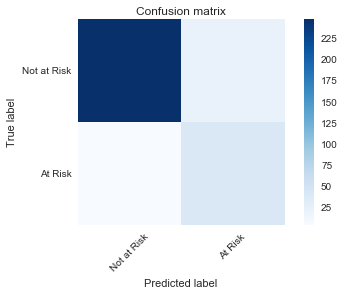

In [399]:
for n in range(1,4):
    print('n = ', n)
    pol_modeling.get_single_model(model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.11624623  0.10279617  0.11928315  0.17029404  0.13046064  0.15436553
  0.20655425]
Accuracy: 0.9537142857142858
Precision: 0.8503097825708151
Recall: 0.8425531914893617
f1: 0.8444345870307346
ROC AUC: 0.9078810733566212


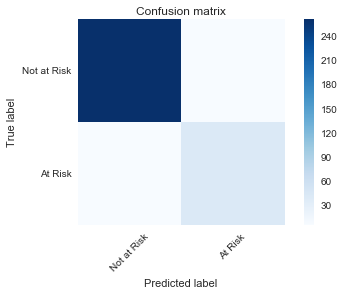

In [363]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.11862208  0.10131816  0.12073699  0.16691143  0.13025031  0.15485032
  0.20731072]
Accuracy: 0.9554285714285713
Precision: 0.8610334582774078
Recall: 0.84
f1: 0.8488508272481375
ROC AUC: 0.9078358208955225


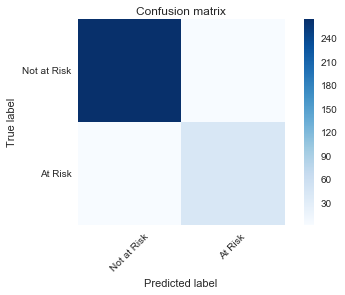

In [364]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.11003149  0.1126935   0.10706353  0.19668732  0.15238484  0.11375618
  0.20738314]
Accuracy: 0.9326349206349207
Precision: 0.7952002850644498
Recall: 0.7442553191489361
f1: 0.7666544001721708
ROC AUC: 0.8549634804699905


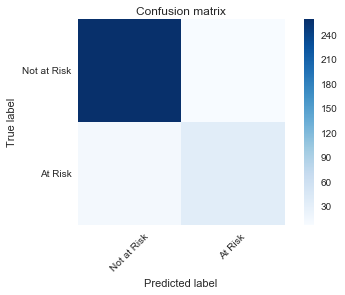

In [365]:
pol_modeling.get_single_model(model=DecisionTreeClassifier(), get_cm = True)

### Random forest, different number of trees

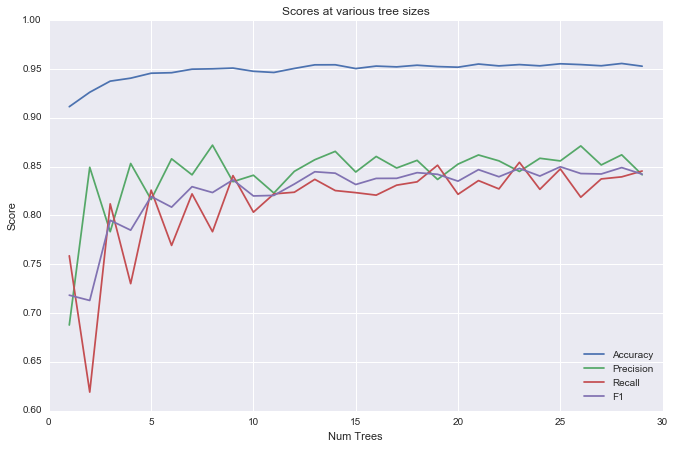

In [366]:
forest_acc = []
forest_prec = []
forest_rec = []
forest_f1 = []
forest_range = list(range(1,30))
for trees in forest_range:
    acc, prec, rec, f1, _ = pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=trees), verbose=False)
    forest_acc.append(acc)
    forest_prec.append(prec)
    forest_rec.append(rec)
    forest_f1.append(f1)

plt.figure(figsize=(11,7))
plt.plot(forest_range, forest_acc, label='Accuracy')
plt.plot(forest_range, forest_prec,label='Precision')
plt.plot(forest_range, forest_rec,label='Recall')
plt.plot(forest_range, forest_f1,label='F1')

plt.legend(loc='best')
plt.xlabel('Num Trees')
plt.ylabel('Score')
plt.title('Scores at various tree sizes')
plt.show()

    

## Testing for a single year

### With Oversampling

In [378]:
pol_modeling.get_multi_models(year=2013)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.973750,0.888816,0.944615,0.914414,0.961708
SVC(),0.966136,0.880846,0.893077,0.885880,0.935938
LogisticRegression(),0.701250,0.288855,0.696154,0.408086,0.699144
BernoulliNB(),0.784091,0.200000,0.153846,0.173913,0.523590
GaussianNB(),0.607159,0.227437,0.691538,0.342137,0.642036
RandomForestClassifier(n_estimators=30),0.975455,0.919384,0.916154,0.916882,0.950944
DecisionTreeClassifier(),0.969545,0.903841,0.891538,0.896095,0.937303


In [379]:
pol_modeling.get_multi_models(year=2012)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.985455,0.958417,0.950714,0.954118,0.971371
SVC(),0.980341,0.914809,0.967143,0.939906,0.974990
LogisticRegression(),0.681136,0.284453,0.662143,0.397826,0.673436
BernoulliNB(),0.771932,0.248237,0.195000,0.209739,0.538041
GaussianNB(),0.587727,0.233024,0.692857,0.348598,0.630347
RandomForestClassifier(n_estimators=30),0.987045,0.967800,0.951429,0.958999,0.972606
DecisionTreeClassifier(),0.986023,0.971202,0.940714,0.955037,0.967654


Avg Feature Importance: None
Accuracy: 0.9848863636363636
Precision: 0.9567883933353343
Recall: 0.9492857142857143
f1: 0.9522242288207127
ROC AUC: 0.970453667953668


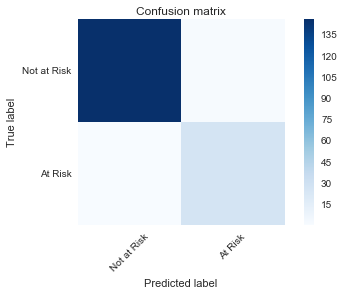

In [380]:
pol_modeling.get_single_model(year=2012, get_cm=True)

In [381]:
pol_modeling.get_multi_models(year=2011, year_delta=1)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.968439,0.933328,0.851538,0.889872,0.920327
SVC(),0.967746,0.872256,0.920769,0.895441,0.948412
LogisticRegression(),0.669017,0.258922,0.645385,0.369458,0.659291
BernoulliNB(),0.791908,0.187500,0.115385,0.142857,0.513475
GaussianNB(),0.594220,0.227118,0.706154,0.343574,0.640288
RandomForestClassifier(n_estimators=30),0.969480,0.943347,0.848462,0.892733,0.919673
DecisionTreeClassifier(),0.963237,0.929916,0.817692,0.869209,0.903336


In [382]:
pol_modeling.get_multi_models(year=2011, year_delta=2)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.939767,0.785518,0.783333,0.783870,0.874234
SVC(),0.946512,0.767466,0.885000,0.821640,0.920743
LogisticRegression(),0.675581,0.252453,0.674167,0.367221,0.674989
BernoulliNB(),0.790698,0.125000,0.083333,0.100000,0.494369
GaussianNB(),0.606047,0.228610,0.765000,0.351814,0.672635
RandomForestClassifier(n_estimators=30),0.938372,0.784269,0.770000,0.776691,0.867838
DecisionTreeClassifier(),0.933837,0.770794,0.750833,0.759692,0.857173


In [384]:
#full_data[full_data.zscores == 1]